# How to debug a model

There are various levels on which to debug a model. One of the simplest is to just print out the values that different variables are taking on.

Because `PyMC3` uses `Theano` expressions to build the model, and not functions, there is no way to place a `print` statement into a likelihood function. Instead, you can use the `Theano` `Print` operatator. For more information, see:  theano Print operator for this before: http://deeplearning.net/software/theano/tutorial/debug_faq.html#how-do-i-print-an-intermediate-value-in-a-function.

Let's build a simple model with just two parameters:

In [1]:
%matplotlib inline

import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import theano.tensor as tt

x = np.random.randn(100)

with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    sd = pm.Normal('sd', mu=0, sigma=1)

    obs = pm.Normal('obs', mu=mu, sigma=sd, observed=x)
    step = pm.Metropolis()
    trace = pm.sample(5000, step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [sd]
>Metropolis: [mu]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 15 seconds.
/env/miniconda3/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [2]:
trace['mu']

array([0., 0., 0., ..., 0., 0., 0.])

Hm, looks like something has gone wrong, but what? Let's look at the values getting proposed using the `Print` operator:

In [3]:
with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    sd = pm.Normal('sd', mu=0, sigma=1)
    
    mu_print = tt.printing.Print('mu')(mu)
    sd_print = tt.printing.Print('sd')(sd)
    
    obs = pm.Normal('obs', mu=mu_print, sigma=sd_print, observed=x)
    step = pm.Metropolis()
    trace = pm.sample(3, step, tune=0, chains=1, progressbar=False) # Make sure not to draw too many samples

mu __str__ = 0.0
sd __str__ = 0.0


Only 3 samples in chain.
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [sd]
>Metropolis: [mu]
Sampling 1 chain for 0 tune and 3 draw iterations (0 + 3 draws total) took 0 seconds.
/dependencies/arviz/arviz/data/base.py:146: UserWarning: More chains (3) than draws (2). Passed array should have shape (chains, draws, *shape)
  UserWarning,


sd __str__ = 1.753782660690967
mu __str__ = 0.0
sd __str__ = 0.0
sd __str__ = 0.0
mu __str__ = -1.179953715933347
mu __str__ = 0.0
sd __str__ = -0.7921743241812005
mu __str__ = 0.0
sd __str__ = 0.0
sd __str__ = 0.0
mu __str__ = -1.6164899771368246
mu __str__ = 0.0
sd __str__ = 1.7649365130019956
mu __str__ = 0.0
sd __str__ = 0.0
sd __str__ = 0.0
mu __str__ = 0.5633904409221188
mu __str__ = 0.0
sd __str__ = 0.0
mu __str__ = 0.0
sd __str__ = 0.0
mu __str__ = 0.0
sd __str__ = 0.0
mu __str__ = 0.0


/dependencies/pymc3/pymc3/sampling.py:603: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


In the code above, we set the `tune=0, chains=1, progressbar=False` in the `pm.sample`, this is done so that the output is cleaner.

Looks like `sd` is always `0` which will cause the logp to go to `-inf`. Of course, we should not have used a prior that has negative mass for `sd` but instead something like a `HalfNormal`.

We can also redirect the output to a string buffer and access the proposed values later on (thanks to [Lindley Lentati](https://github.com/LindleyLentati) for providing this example):

Only 5 samples in chain.
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [sd]
>Metropolis: [mu]
Sampling 1 chain for 0 tune and 5 draw iterations (0 + 5 draws total) took 0 seconds.
/dependencies/arviz/arviz/data/base.py:146: UserWarning: More chains (5) than draws (2). Passed array should have shape (chains, draws, *shape)
  UserWarning,


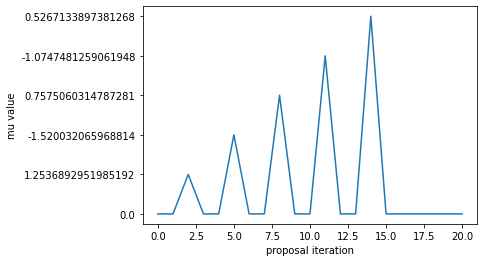

In [4]:
from io import StringIO
import sys

x = np.random.randn(100)

old_stdout = sys.stdout
mystdout = sys.stdout = StringIO()

with pm.Model() as model:
    mu = pm.Normal('mu', mu=0, sigma=1)
    sd = pm.Normal('sd', mu=0, sigma=1)

    mu_print = tt.printing.Print('mu')(mu)
    sd_print = tt.printing.Print('sd')(sd)

    obs = pm.Normal('obs', mu=mu_print, sigma=sd_print, observed=x)
    step = pm.Metropolis()
    trace = pm.sample(5, step, tune=0, chains=1, progressbar=False) # Make sure not to draw too many samples

sys.stdout = old_stdout

output = mystdout.getvalue().split('\n')
mulines = [s for s in output if 'mu' in s]

muvals = [line.split()[-1] for line in mulines]
plt.plot(np.arange(0, len(muvals)), muvals)
plt.xlabel('proposal iteration')
plt.ylabel('mu value');

In [5]:
trace['mu']

array([0., 0., 0., 0., 0.])

Notice that for each iteration, 3 values were printed and recorded. The printed values are the original value (last sample), the proposed value and the accepted value. Plus the starting value in the very beginning, we recorded in total `1+3*5=16` value above.

In [6]:
%load_ext watermark
%watermark -n -u -v -iv -w

seaborn 0.10.1
pandas  1.0.4
pymc3   3.9.0
numpy   1.18.5
last updated: Fri Jun 12 2020 

CPython 3.7.7
IPython 7.15.0
watermark 2.0.2
